# Step 1: Cargando los datos y las librerías

Genius is one percent inspiration and 99 percent perspiration
-- ~~Thomas Edison~~ Kate Sanborn

In [1]:
# Limpiamos el entorno
rm(list = ls())
gc(verbose = FALSE)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,627610,33.6,1404602,75.1,994520,53.2
Vcells,1149698,8.8,8388608,64.0,1769393,13.5


In [2]:
# Librerías necesarias
require("data.table")
require("rpart")
require("ggplot2")
require("dplyr")

Loading required package: data.table

Loading required package: rpart

Loading required package: ggplot2

Loading required package: dplyr


Attaching package: 'dplyr'


The following objects are masked from 'package:data.table':

    between, first, last


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [3]:
# Aqui se debe poner la carpeta de la materia de SU computadora local
setwd("C:/Users/German/Desktop/dmeyf2023/German/Clase 1") # Establezco el Working Directory

# Poner sus semillas
semillas <- c(279511, 279523, 279541, 279551, 279571)

In [4]:
# Cargamos el dataset
dataset <- fread("competencia_01.csv")

# Nos quedamos solo con el 202103
dataset <- dataset[foto_mes == 202103]

In [5]:
# Creamos una clase binaria
dataset[, clase_binaria := ifelse(
                            clase_ternaria == "BAJA+2",
                                "evento",
                                "noevento"
                            )]
# Borramos el target viejo
dataset[, clase_ternaria := NULL]

set.seed(semillas[1])

calcular_ganancia <- function(modelo, test) {
    pred_testing <- predict(modelo, test, type = "prob")
    sum(
        (pred_testing[, "evento"] >= 0.025) * ifelse(test$clase_binaria == "evento",
                                          273000, -7000) / 0.3
    )
}

# Step 2: Importancia de variables

In [6]:
# Particionamos de forma estratificada
in_training <- caret::createDataPartition(dataset$clase_binaria,
                     p = 0.70, list = FALSE)
dtrain  <-  dataset[in_training, ]
dtest   <-  dataset[-in_training, ]

In [7]:
# Antes de empezar vamos a ver la importancia de variables
modelo <- rpart(clase_binaria ~ .,
                data = dtrain,
                xval = 0,
                cp = -1,
                minsplit = 1000,
                minbucket = 40,
                maxdepth = 7)

calcular_ganancia(modelo, dtest)
print(modelo$variable.importance)

[1] 83673333

                     ctrx_quarter                       Visa_status 
                     2.756308e+01                      1.387882e+01 
         cdescubierto_preacordado                    mcuentas_saldo 
                     1.352785e+01                      1.094682e+01 
            mprestamos_personales             cprestamos_personales 
                     1.066534e+01                      9.705876e+00 
                mcuenta_corriente                   mactivos_margen 
                     8.979297e+00                      8.555482e+00 
                  mpasivos_margen                      mcaja_ahorro 
                     7.236420e+00                      7.171977e+00 
        mcomisiones_mantenimiento         ccomisiones_mantenimiento 
                     6.631820e+00                      5.813721e+00 
                ccomisiones_otras                     Master_status 
                     5.567390e+00                      5.350996e+00 
                   active_quarter 

**Preguntas**
- ¿Cuáles son las variables más importantes para el modelo?
- ¿Cómo calcula RPART la importancia de una variable?
- ¿Es la única forma de calcular la importancia de una variable?

# Step 3: Datos nulos

In [8]:
# Tenemos variables con nulos en el dataset?
summary(dtrain)

 numero_de_cliente      foto_mes      active_quarter    cliente_vip      
 Min.   : 29183981   Min.   :202103   Min.   :0.0000   Min.   :0.000000  
 1st Qu.: 60732324   1st Qu.:202103   1st Qu.:1.0000   1st Qu.:0.000000  
 Median : 85532032   Median :202103   Median :1.0000   Median :0.000000  
 Mean   : 90117496   Mean   :202103   Mean   :0.9863   Mean   :0.002711  
 3rd Qu.:116915971   3rd Qu.:202103   3rd Qu.:1.0000   3rd Qu.:0.000000  
 Max.   :186140768   Max.   :202103   Max.   :1.0000   Max.   :1.000000  
                                                                         
    internet        cliente_edad   cliente_antiguedad mrentabilidad      
 Min.   :0.00000   Min.   :18.00   Min.   :  1.0      Min.   :-194044.0  
 1st Qu.:0.00000   1st Qu.:37.00   1st Qu.: 61.0      1st Qu.:    -48.2  
 Median :0.00000   Median :45.00   Median :127.0      Median :   1246.9  
 Mean   :0.05215   Mean   :46.87   Mean   :133.8      Mean   :   2440.4  
 3rd Qu.:0.00000   3rd Qu.:56.00   3rd

In [9]:
# En el summary del modelo buscamos un corte donde la primera variable
# tenga missing.
summary(modelo)

Call:
rpart(formula = clase_binaria ~ ., data = dtrain, xval = 0, cp = -1, 
    minsplit = 1000, minbucket = 40, maxdepth = 7)
  n= 114328 

  CP nsplit rel error
1  0      0         1
2 -1     37         1

Variable importance
               ctrx_quarter                 Visa_status 
                         14                           7 
   cdescubierto_preacordado              mcuentas_saldo 
                          7                           6 
      mprestamos_personales       cprestamos_personales 
                          6                           5 
          mcuenta_corriente             mactivos_margen 
                          5                           4 
            mpasivos_margen                mcaja_ahorro 
                          4                           4 
  mcomisiones_mantenimiento   ccomisiones_mantenimiento 
                          3                           3 
          ccomisiones_otras               Master_status 
                          3    

**Preguntas**
- ¿Cómo operó con la variable nula?
- ¿Hace falta imputar las variables para que el árbol abra?

In [10]:
# Actividad en clase:
# -------------------

# Impute una variable que sea importante y vea si mejora tanto su ganancia
# y su importancia. Un ejemplo

experimento <- function(ds, semillas, cp = -1, minsplit = 1000, minbucket = 200, maxdepth = 7) {
    gan <- c()
    for (s in semillas) {
        set.seed(s)
        in_training <- caret::createDataPartition(ds$clase_binaria, p = 0.70,
            list = FALSE)
        train  <-  dataset[in_training, ]
        test   <-  dataset[-in_training, ]

        r <- rpart(clase_binaria ~ .,
                    data = train,
                    xval = 0,
                    cp = cp,
                    minsplit = minsplit,
                    minbucket = minbucket,
                    maxdepth = maxdepth)

        gan <- c(gan, calcular_ganancia(r, test))
    }
    print(mean(gan))
    r <- rpart(clase_binaria ~ .,
            data = ds,
            xval = 0,
            cp = cp,
            minsplit = minsplit,
            minbucket = minbucket,
            maxdepth = maxdepth)
    print(r$variable.importance)
}
experimento(dataset, semillas)

[1] 86608667
                        ctrx_quarter                       mcuentas_saldo 
                        4.127537e+01                         2.287475e+01 
                   mcuenta_corriente                         mcaja_ahorro 
                        1.801011e+01                         1.642235e+01 
                ccajas_transacciones                mprestamos_personales 
                        1.561809e+01                         1.516117e+01 
               cprestamos_personales                      mactivos_margen 
                        1.401629e+01                         1.359414e+01 
                    ccajas_consultas             cdescubierto_preacordado 
                        1.253243e+01                         1.059381e+01 
           mcomisiones_mantenimiento                      mpasivos_margen 
                        1.027260e+01                         9.699559e+00 
           ccomisiones_mantenimiento                    ccomisiones_otras 
            

In [11]:
# Imputamos los nulos de una variable con ceros
print(sum(is.na(dataset$Visa_mlimitecompra)))
dataset[, Visa_mlimitecompra_2 := ifelse(is.na(Visa_mlimitecompra), 0, Visa_fechaalta)]
experimento(dataset, semillas)

## Comparta sus resultados

[1] 7831
[1] 86492000
                        ctrx_quarter                       mcuentas_saldo 
                        4.127537e+01                         2.287475e+01 
                   mcuenta_corriente                         mcaja_ahorro 
                        1.801012e+01                         1.632994e+01 
                ccajas_transacciones                mprestamos_personales 
                        1.561809e+01                         1.517995e+01 
               cprestamos_personales                      mactivos_margen 
                        1.401629e+01                         1.359305e+01 
                    ccajas_consultas             cdescubierto_preacordado 
                        1.253243e+01                         1.061908e+01 
           mcomisiones_mantenimiento                      mpasivos_margen 
                        1.027240e+01                         9.597981e+00 
           ccomisiones_mantenimiento                    ccomisiones_otras 
   

# Step 4: Correlaciones

Varios modelos en los que entren dos variables muy correlacionadas se romperían. Sucede esto con los árboles?

Actividad en clase: Cree una variable muy correlacionada con su mejor variables y comparta que sucede.


# Step 5: Outliers

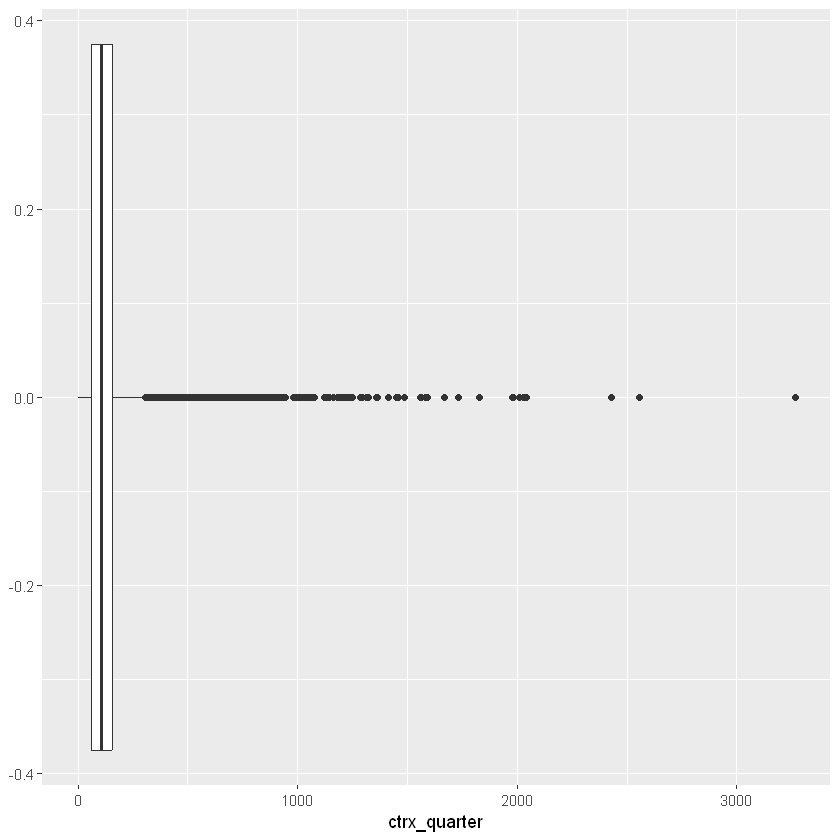

In [12]:
# Veamos el boxplot de una variable muy importante según nuestro árbol
ggplot(dataset, aes(x=ctrx_quarter)) + geom_boxplot()

In [13]:
# Vemos la distribución de los deciles
quantile(dataset$ctrx_quarter, probs = c(0,0.5, 0.75, 0.9, 0.95, 0.99, 1))

0%  50%  75%  90%  95%  99% 100% 
   0  105  158  218  267  412 3265

**Preguntas**
- ¿Qué tan frecuentes considera estas dispersiones en los datasets?

In [14]:
# Reduzcamos la enorme disperción usando un logaritmo
dataset[, ctrx_quarter_2 := log(ctrx_quarter + 1)]
quantile(dataset$ctrx_quarter_2, probs = c(0,0.5, 0.75, 0.9, 0.95, 0.99, 1))

0%      50%      75%      90%      95%      99%     100% 
0.000000 4.663439 5.068904 5.389072 5.590987 6.023448 8.091321

In [15]:
# Comparemos dos splits
modelo_cq_1 <- rpart(clase_binaria ~ ctrx_quarter,
                    data = dataset,
                    xval = 0,
                    cp = -1,
                    maxdepth = 1)
modelo_cq_2 <- rpart(clase_binaria ~ ctrx_quarter_2,
                    data = dataset,
                    xval = 0,
                    cp = -1,
                    maxdepth = 1)

In [16]:
print(modelo_cq_1)

n= 163324 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

1) root 163324 1049 noevento (0.006422816 0.993577184)  
  2) ctrx_quarter< 17.5 10372  477 noevento (0.045989202 0.954010798) *
  3) ctrx_quarter>=17.5 152952  572 noevento (0.003739735 0.996260265) *


In [17]:
print(modelo_cq_2)

n= 163324 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

1) root 163324 1049 noevento (0.006422816 0.993577184)  
  2) ctrx_quarter_2< 2.917405 10372  477 noevento (0.045989202 0.954010798) *
  3) ctrx_quarter_2>=2.917405 152952  572 noevento (0.003739735 0.996260265) *


**Preguntas**
- Mirando los puntos de corte de los dos modelos ¿Existe una relación matermática entre ellos?
- ¿Es útil una transformación monótona en los árboles de decisión?

# Step 6: Data drifting

**Actividad en clase**: Qué es y como lo solucionamos